## Problem statement
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## DataSet Overview
The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
 -Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

### Importing Skin Cancer Data

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# download dataset from google drive

# unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip"

Archive:  /content/gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
# Unzipped content with folders will be seen in files section of google collab and same path can be provided with root /content/ for reading the same.
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

Signature: tf.keras.preprocessing.image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(2 items) (256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, **kwargs)
Docstring:
Generates a `tf.data.Dataset` from image files in a directory.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

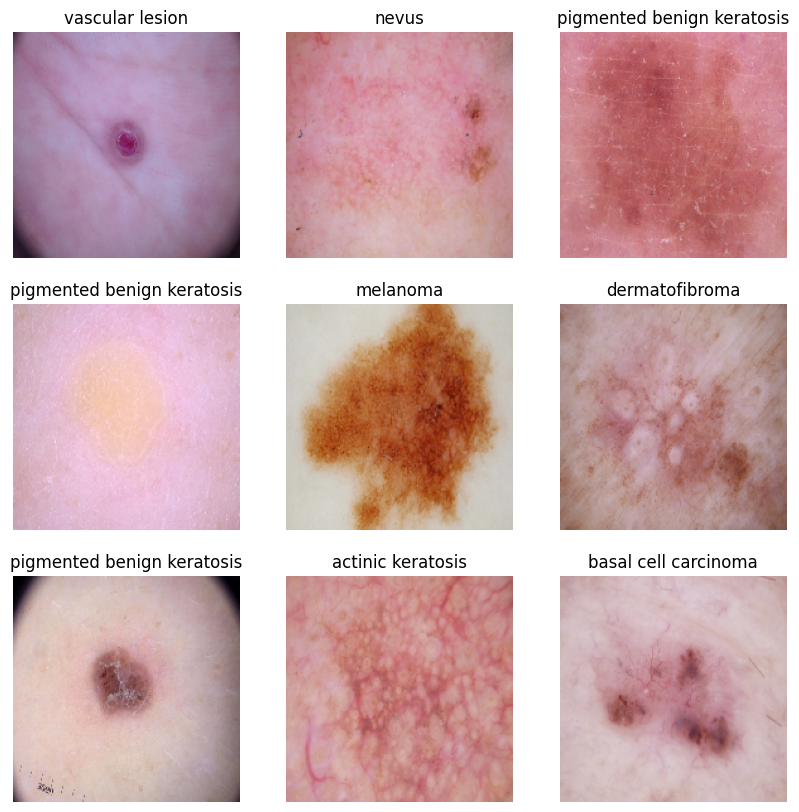

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
# ?Conv2D

In [13]:
input_shape = (180,180,3)

model = Sequential()

# pre-processing - rescaling of pixels to 0-1
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=input_shape))

# convolutional layer with 32 feature layers
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))

# pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))

# convolutional layer with 64 feature layer
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))

# pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))

# convolutional layer with 64 feature layer
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))

# pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())

# Dense layer or fully connected layer
model.add(Dense(512, activation='relu'))

# output layer
model.add(Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       7

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### loss function for classification in CNN is typically sparse_categorical_crossentropy
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       7

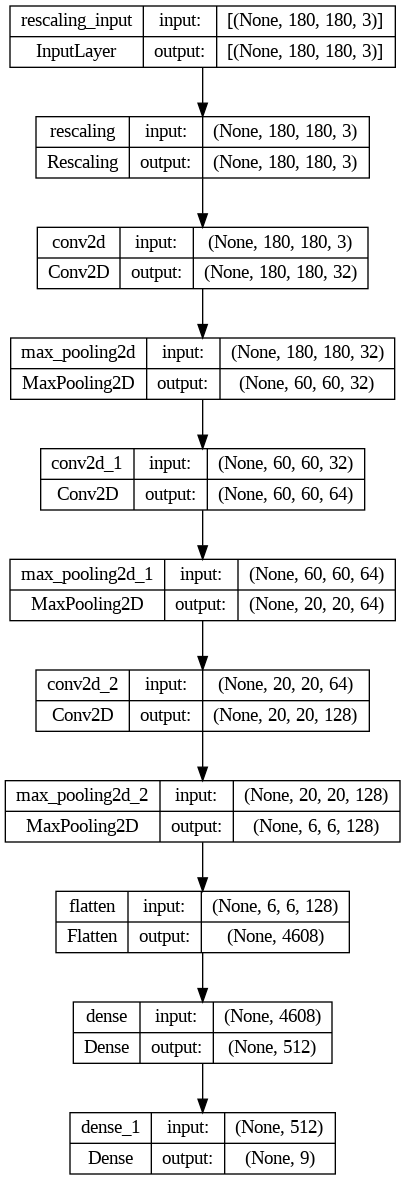

In [17]:
# vizualizing the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 21s 84ms/step - loss: 1.9848 - accuracy: 0.2394 - val_loss: 1.7718 - val_accuracy: 0.3960
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7452 - accuracy: 0.3571 - val_loss: 1.5980 - val_accuracy: 0.4497
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5286 - accuracy: 0.4464 - val_loss: 1.4569 - val_accuracy: 0.5190
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4135 - accuracy: 0.4972 - val_loss: 1.4448 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4165 - accuracy: 0.4933 - val_loss: 1.4001 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2808 - accuracy: 0.5435 - val_loss: 1.3167 - val_accuracy: 0.5570
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2529 - accuracy: 0.5446 - val_loss: 1.3154 - val_accuracy: 0.5459
Epoch 8/20
5

### Visualizing training results

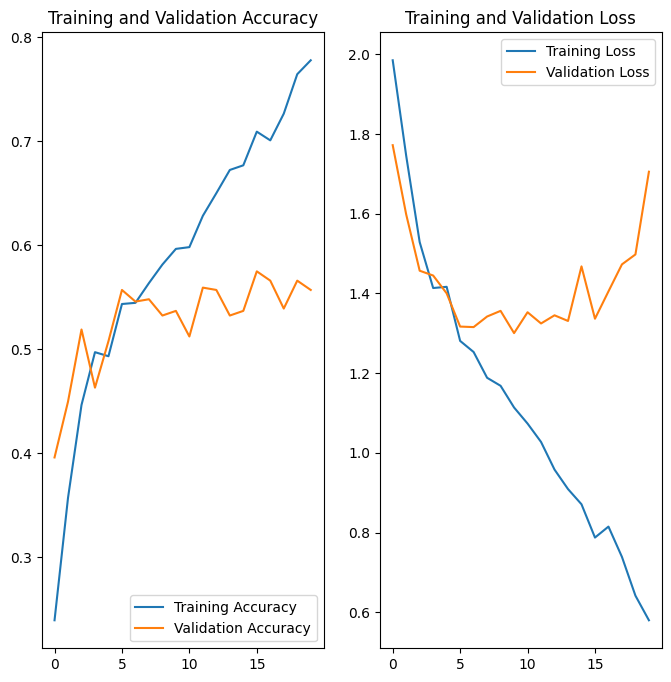

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [20]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 9ms/step - loss: 1.7052 - accuracy: 0.5570
Accuracy:  0.8097098469734192
Validation Accuracy:  0.5570470094680786
Loss:  0.5400605797767639
Validation Loss 1.705241322517395


### Write your findings here

### Model Overfit or Underfit?
The model seems overfitting with training accuracy (80.8%) and validation accuracy (55.7%)

In [21]:
# Model is overfitting, will use the below data augumentation strategy of flipping, rotating, zoom
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

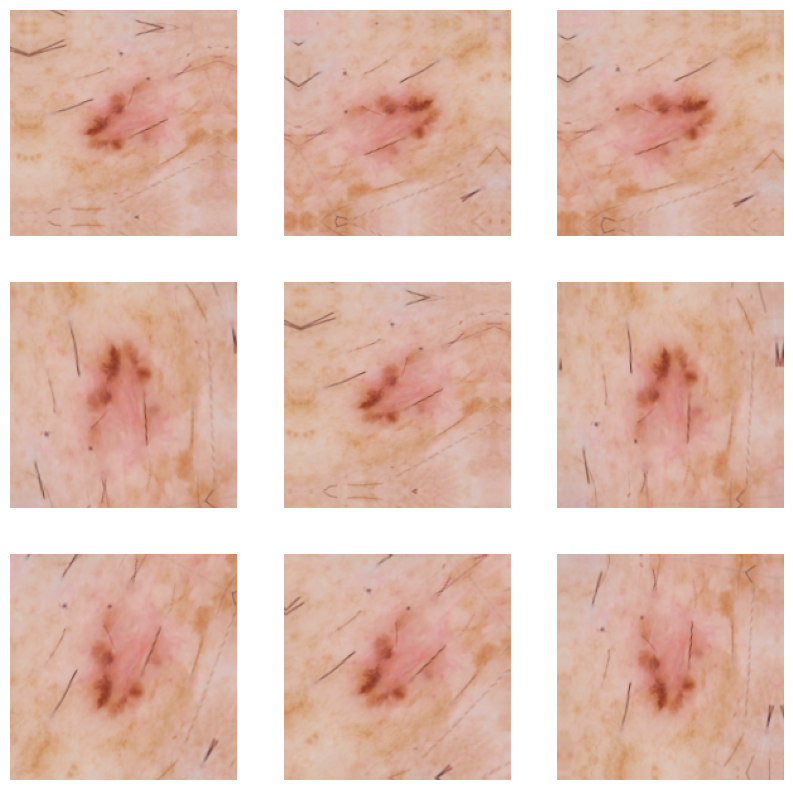

In [22]:
# Visualize how your augmentation strategy works for one instance of training image.

for images, labels in train_ds.take(1):
    sample_image = images[0]
    sample_label = labels[0]

# Apply augmentation multiple times to visualize different transformations
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

plt.show()

### Create the model with augmentation, compile and train the model


In [23]:
input_shape = (180,180,3)

model = Sequential()

# pre-processing - rescaling of pixels to 0-1
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=input_shape))

# convolutional layer with 32 feature layers
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))

# pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# convolutional layer with 64 feature layer
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))

# pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# convolutional layer with 64 feature layer
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))

# pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())

# Dense layer or fully connected layer
model.add(Dense(512, kernel_regularizer=l2(0.01), activation='relu'))
model.add(Dropout(0.25))

# output layer
model.add(Dense(len(class_names),activation='softmax'))

# Build the model
model.build((None, 180, 180, 3))

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 60, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 64)        0         
 g2D)                                                 

### Compiling the model

In [24]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 36ms/step - loss: 4.9890 - accuracy: 0.2009 - val_loss: 2.4362 - val_accuracy: 0.2662
Epoch 2/20
56/56 [==============================] - 2s 34ms/step - loss: 2.0613 - accuracy: 0.3225 - val_loss: 1.9711 - val_accuracy: 0.3132
Epoch 3/20
56/56 [==============================] - 2s 33ms/step - loss: 1.7756 - accuracy: 0.3878 - val_loss: 1.9326 - val_accuracy: 0.3356
Epoch 4/20
56/56 [==============================] - 2s 32ms/step - loss: 1.7244 - accuracy: 0.3990 - val_loss: 1.7506 - val_accuracy: 0.4407
Epoch 5/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6415 - accuracy: 0.4637 - val_loss: 1.6312 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6327 - accuracy: 0.4609 - val_loss: 1.7588 - val_accuracy: 0.4072
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6109 - accuracy: 0.4665 - val_loss: 1.6826 - val_accuracy: 0.4407
Epoch 8/20
56

### Visualizing the results

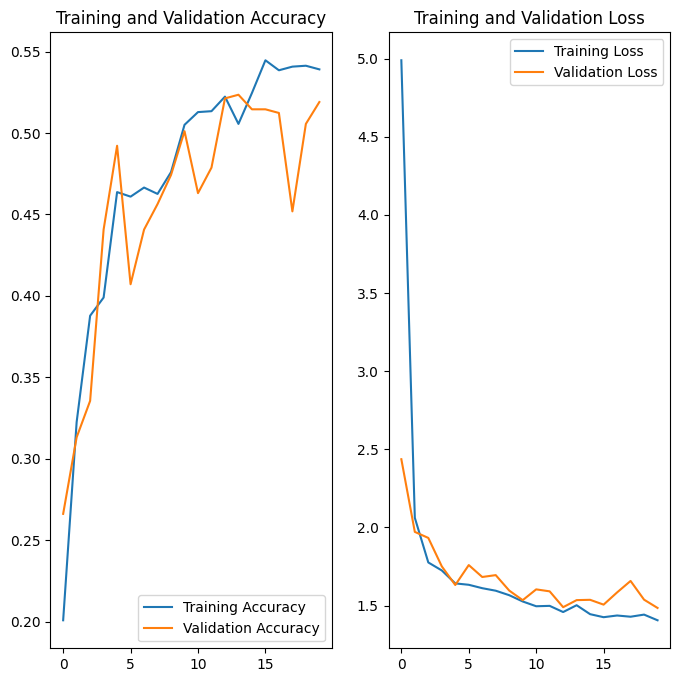

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 10ms/step - loss: 1.4845 - accuracy: 0.5190
Accuracy:  0.5691964030265808
Validation Accuracy:  0.5190156698226929
Loss:  1.3849284648895264
Validation Loss 1.4845123291015625


#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
Model is no longer overfitting and is giving similar results for training data (56.5%) and validation data (52.5%). The accuracy % on training data also reduced but accuracy % of validation dataset is still low and we can say that it is a bit underfitting with only 52-56% accuracy.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
# Collect all labels from the dataset
labels_list = []
for images, labels in train_ds:
    labels_list.extend(labels.numpy())

# Convert labels to DataFrame
df = pd.DataFrame(labels_list, columns=['label'])

# Map label indices to class names
df['class_name'] = df['label'].apply(lambda x: class_names[x])

# Calculate class distribution
class_distribution = df['class_name'].value_counts().reset_index()
class_distribution.columns = ['class_name', 'count']

print(class_distribution)

                   class_name  count
0  pigmented benign keratosis    370
1                    melanoma    352
2        basal cell carcinoma    309
3                       nevus    277
4     squamous cell carcinoma    142
5             vascular lesion    115
6           actinic keratosis     92
7              dermatofibroma     77
8        seborrheic keratosis     58


#### Write your findings here:
#### - Which class has the least number of samples?
seborrheic keratosis: 58
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis: 370


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E2D755672B0>: 100%|██████████| 500/500 [00:18<00:00, 26.49 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E2D755DCE80>: 100%|██████████| 500/500 [00:20<00:00, 23.91 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E2D754BC7F0>: 100%|██████████| 500/500 [00:19<00:00, 25.91 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E2D505695D0>: 100%|██████████| 500/500 [01:20<00:00,  6.18 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E2D753F6440>: 100%|██████████| 500/500 [01:13<00:00,  6.77 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E2D75526F80>: 100%|██████████| 500/500 [00:15<00:00, 32.37 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E2D75626B30>: 100%|██████████| 500/500 [00:35<00:00, 13.89 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E2D75524DC0>: 100%|██████████| 500/500 [00:15<00:00, 32.50 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E2D7550D2D0>: 100%|██████████| 500/500 [00:15<00:00, 33.26 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025350.jpg_bf643aa9-d6ce-42a3-a16e-bc6ea2214a0b.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029567.jpg_f2655b7a-6998-4e6b-b8a2-d21213a6e3ad.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027303.jpg_939d5c8f-7079-4851-aef7-3d028d0a08e9.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032897.jpg_1d77a08f-9fc9-4ae5-82c2-cdfd63fcfe32.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027700.jpg_b05663fc-c1b7-4dff-91b6-ed62

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [34]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [35]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df['Label'].value_counts()

Label
squamous cell carcinoma       500
seborrheic keratosis          500
nevus                         500
dermatofibroma                500
basal cell carcinoma          500
actinic keratosis             500
vascular lesion               500
pigmented benign keratosis    500
melanoma                      500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [37]:
# path to directory with training data + data created using augmentor - since it is subdirectory under Train, Train dir should be sufficient
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [39]:
# Cache the images for faster executions after first epoch
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Create your model (make sure to include normalization)

In [40]:
input_shape = (180,180,3)

model = Sequential()

# pre-processing - rescaling of pixels to 0-1
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=input_shape))

# convolutional layer with 32 feature layers
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
# Batch Normalization
model.add(BatchNormalization())

# pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# convolutional layer with 64 feature layer
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
# Batch Normalization
model.add(BatchNormalization())

# pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# convolutional layer with 128 feature layer
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
# Batch Normalization
model.add(BatchNormalization())

# pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())

# Dense layer or fully connected layer
model.add(Dense(512, kernel_regularizer=l2(0.01), activation='relu'))
# Batch Normalization
model.add(BatchNormalization())
model.add(Dropout(0.25))

# output layer
model.add(Dense(len(class_names),activation='softmax'))

# Build the model
model.build((None, 180, 180, 3))

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 60, 60, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 60, 60, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 64)       

#### Compile your model (Choose optimizer and loss function appropriately)

In [41]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Train your model

In [42]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 47s 82ms/step - loss: 7.3118 - accuracy: 0.4162 - val_loss: 6.7283 - val_accuracy: 0.1448
Epoch 2/30
169/169 [==============================] - 8s 50ms/step - loss: 3.1672 - accuracy: 0.5035 - val_loss: 6.0461 - val_accuracy: 0.1299
Epoch 3/30
169/169 [==============================] - 8s 49ms/step - loss: 2.3992 - accuracy: 0.5252 - val_loss: 8.7362 - val_accuracy: 0.1010
Epoch 4/30
169/169 [==============================] - 8s 49ms/step - loss: 2.2606 - accuracy: 0.5666 - val_loss: 7.0476 - val_accuracy: 0.1128
Epoch 5/30
169/169 [==============================] - 8s 49ms/step - loss: 2.2688 - accuracy: 0.5844 - val_loss: 3.0627 - val_accuracy: 0.3422
Epoch 6/30
169/169 [==============================] - 8s 48ms/step - loss: 2.2340 - accuracy: 0.6055 - val_loss: 2.8510 - val_accuracy: 0.4588
Epoch 7/30
169/169 [==============================] - 8s 50ms/step - loss: 2.1795 - accuracy: 0.6413 - val_loss: 2.8021 - val_accuracy: 0.490

#### Visualize the model results

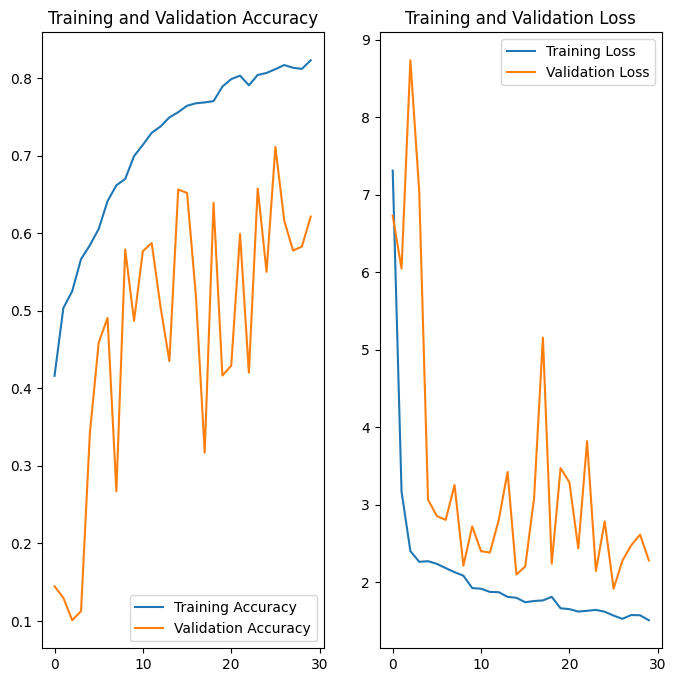

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 0s 10ms/step - loss: 2.2777 - accuracy: 0.6214
Accuracy:  0.6669139266014099
Validation Accuracy:  0.6213808655738831
Loss:  2.1198136806488037
Validation Loss 2.277651071548462


#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
After class rebalancing, the training data accuracy is 67% and validation data accuracy is 63.8%. The overall accuracy of th model increased by 10-12% after class rebalancing. But the model seems to have overfitted with increase in the number of epochs.


In [45]:
# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.


In [46]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {accuracy:.4f}")

4/4 [==============================] - 5s 111ms/step - loss: 5.0011 - accuracy: 0.3729
Test accuracy: 0.3729
